In [1]:
import cPickle as pickle
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
model_path = "/sharp/djgagne/track_models_spring2015_cqg_masked/"
model_params = dict(microphysics="MY",
                    model_name="Random-Forest",
                    model_type="condition")
with open(model_path + "{microphysics:s}_{model_name:s}_{model_type:s}.pkl".format(**model_params)) as mo:
    model_obj = pickle.load(mo)
print(model_obj)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=20,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [5, 10, 20], 'max_features': ['sqrt', 20, 30, 50]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)


In [73]:
storm_variables = ["uh_max", "r10cmx", "wupmax", "cqgmax", "wdnmax", "echotp", "accppt", "pwat",
                   "bku", "bkv"]
potential_variables = ["mlcape", "mlcins", "mucape", "mucins", "sblcl", "srh03", "shr06", "tmp500",
                       "tmp700", "dewp2m", "temp2m", "sph850", "sph700", "sph500", "lllr", "lr75",
                       "u10m", "v10m", "u700", "v700"]
shape_variables = ["area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation",
                   "extent"]
tendency_variables = ["mucape", "dewp2m", "temp2m"]
variable_statistics = ["mean", "max", "min", "std", "skew",
                       "percentile_10", "percentile_50", "percentile_90"]
input_columns = ["Forecast_Hour", "Valid_Hour_UTC", "Duration_Step", "Duration_Total",
                 "Storm_Motion_U", "Storm_Motion_V"]
for var in storm_variables:
    for stat in variable_statistics:
        input_columns.append(var + "_" + stat)
for var in potential_variables:
    for stat in variable_statistics:
        input_columns.append(var + "-potential_" + stat)
for var in tendency_variables:
    for stat in variable_statistics:
        input_columns.append(var + "-tendency_" + stat)
input_columns += shape_variables
input_col_arr = np.array(input_columns)

In [13]:
tree = model_obj.best_estimator_.estimators_[0].tree_

In [48]:
def find_tree_node_levels(tree):
    visited = np.zeros(tree.capacity, dtype=int)
    levels = np.ones(tree.capacity, dtype=int) * -1
    parents = np.ones(tree.capacity, dtype=int) * -1
    current_level = 0
    current_node = 0
    parent_node = -1
    visited_nodes = 0 
    while ~np.all(visited):
        visited_nodes += 1
        if visited[current_node] == 0:
            levels[current_node] = current_level
            visited[current_node] = 1
            parents[current_node] = parent_node
            if tree.children_left[current_node] > -1:
                parent_node = current_node
                current_node = tree.children_left[current_node]
                current_level += 1
            else:
                current_node = parent_node
                parent_node = parents[current_node]
                current_level -= 1
        else:
            if tree.children_right[current_node] != -1 and visited[tree.children_right[current_node]] == 0:
                parent_node = current_node
                current_node = tree.children_right[current_node]
                current_level += 1
            else:
                current_node = parent_node
                parent_node = parents[current_node]
                current_level -= 1
    return levels

In [49]:
all_levels = []
for t, tree in enumerate(model_obj.best_estimator_.estimators_):
    if t % 20 == 0:
        print t,
    all_levels.append(find_tree_node_levels(tree.tree_))

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480


In [9]:
np.concatenate([np.where(tree.children_right == 0)[0], np.where(tree.children_left==0)[0]]).size

0

In [ ]:
v = 5
v -= 1
print v

In [21]:
all_levels

array([0, 1, 2, ..., 7, 8, 8])

In [89]:
all_features = np.arange(model_obj.best_estimator_.n_features_)
level_numbers = np.arange(0, np.max(np.concatenate(all_levels))+1)
level_bins = np.arange(0, np.max(np.concatenate(all_levels))+2)
level_counts = pd.DataFrame(index=all_features, columns=level_numbers, data=np.zeros((all_features.size, level_numbers.size)),dtype=float)
for t, tree in enumerate(model_obj.best_estimator_.estimators_):
    print t,
    tree_level_counts = np.histogram(all_levels[t], bins=level_bins)[0]
    for f in all_features:
        level_counts.loc[f] += np.histogram(all_levels[t][tree.tree_.feature == f], bins=level_bins)[0].astype(float) / tree_level_counts.astype(float)
level_counts /= float(len(all_levels))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

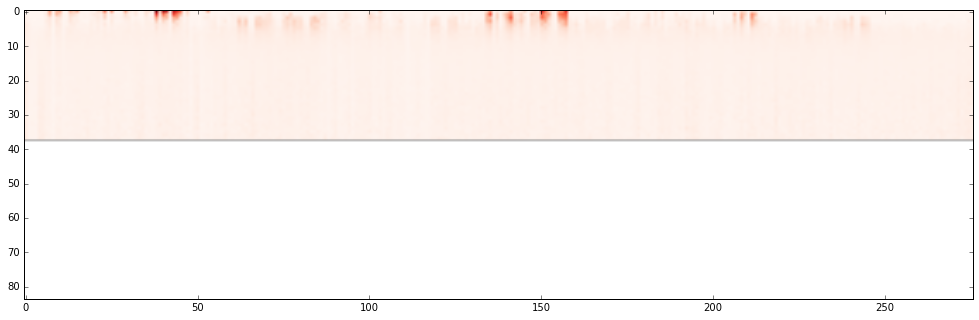

In [90]:
plt.figure(figsize=(17, 10))
plt.imshow(level_counts.T, cmap="Reds")

(array([  11.,   77.,  118.,   42.,   11.,    4.,    4.,    3.,    4.,    2.]),
 array([ 0.00036024,  0.00099566,  0.00163109,  0.00226652,  0.00290194,
         0.00353737,  0.00417279,  0.00480822,  0.00544364,  0.00607907,
         0.0067145 ]),
 <a list of 10 Patch objects>)

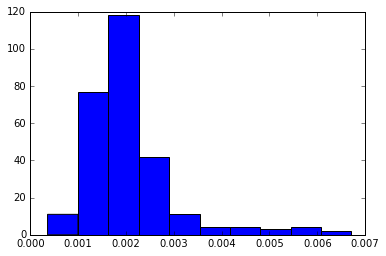

In [91]:
plt.hist(level_counts.mean(axis=1).values)

In [92]:
level_ranks = np.argsort(level_counts.mean(axis=1))
for r, rank in enumerate(level_ranks):
    print r, rank, input_col_arr[rank], level_counts.mean(axis=1)[rank]

0 8 uh_max_min 0.000360238511559
1 111 mucins-potential_max 0.000467434874987
2 48 echotp_min 0.000599086400351
3 2 Duration_Step 0.000669734021326
4 51 echotp_percentile_10 0.000688017824086
5 117 mucins-potential_percentile_90 0.000708793058464
6 3 Duration_Total 0.000783855439551
7 11 uh_max_percentile_10 0.000900890865344
8 1 Valid_Hour_UTC 0.000938231899228
9 95 mlcins-potential_max 0.000944935334759
10 88 mlcape-potential_min 0.000949738161376
11 112 mucins-potential_min 0.00103096151519
12 115 mucins-potential_percentile_10 0.00108979157593
13 113 mucins-potential_std 0.00113969565328
14 116 mucins-potential_percentile_50 0.00119461356642
15 110 mucins-potential_mean 0.00120168951538
16 205 lllr-potential_percentile_90 0.00124199709788
17 104 mucape-potential_min 0.0012433924139
18 52 echotp_percentile_50 0.00126259719324
19 91 mlcape-potential_percentile_10 0.00127395356616
20 204 lllr-potential_percentile_50 0.00128056016043
21 198 lllr-potential_mean 0.00130327043347
22 46 ec

In [178]:
eval_level = 10
valid_vars = level_counts.loc[:, eval_level].values > 0
level_ranking = np.argsort(level_counts.loc[:, eval_level].values[valid_vars])[::-1]
for l, level_rank in enumerate(level_ranking):
    print l, input_col_arr[valid_vars][level_rank], "%0.5f" % level_counts.loc[:, eval_level].values[valid_vars][level_rank]

0 bku_percentile_50 0.00295
1 shr06-potential_max 0.00281
2 bkv_percentile_50 0.00276
3 shr06-potential_percentile_90 0.00275
4 bkv_mean 0.00274
5 bkv_percentile_10 0.00270
6 v700-potential_percentile_90 0.00269
7 sph500-potential_min 0.00265
8 srh03-potential_percentile_10 0.00262
9 tmp700-potential_percentile_90 0.00261
10 bkv_max 0.00259
11 bku_percentile_90 0.00257
12 pwat_percentile_10 0.00257
13 v700-potential_percentile_10 0.00252
14 shr06-potential_mean 0.00252
15 bku_max 0.00251
16 shr06-potential_percentile_50 0.00251
17 bku_mean 0.00250
18 wdnmax_max 0.00247
19 pwat_percentile_50 0.00247
20 v10m-potential_percentile_50 0.00246
21 u10m-potential_percentile_90 0.00245
22 v700-potential_mean 0.00244
23 tmp700-potential_percentile_10 0.00243
24 srh03-potential_mean 0.00242
25 v700-potential_min 0.00242
26 sph500-potential_std 0.00242
27 bkv_percentile_90 0.00241
28 sblcl-potential_percentile_10 0.00240
29 sph500-potential_percentile_10 0.00239
30 v10m-potential_percentile_90 0.0

In [129]:
for c, col in enumerate(input_col_arr):
    print c, col

0 Forecast_Hour
1 Valid_Hour_UTC
2 Duration_Step
3 Duration_Total
4 Storm_Motion_U
5 Storm_Motion_V
6 uh_max_mean
7 uh_max_max
8 uh_max_min
9 uh_max_std
10 uh_max_skew
11 uh_max_percentile_10
12 uh_max_percentile_50
13 uh_max_percentile_90
14 r10cmx_mean
15 r10cmx_max
16 r10cmx_min
17 r10cmx_std
18 r10cmx_skew
19 r10cmx_percentile_10
20 r10cmx_percentile_50
21 r10cmx_percentile_90
22 wupmax_mean
23 wupmax_max
24 wupmax_min
25 wupmax_std
26 wupmax_skew
27 wupmax_percentile_10
28 wupmax_percentile_50
29 wupmax_percentile_90
30 cqgmax_mean
31 cqgmax_max
32 cqgmax_min
33 cqgmax_std
34 cqgmax_skew
35 cqgmax_percentile_10
36 cqgmax_percentile_50
37 cqgmax_percentile_90
38 wdnmax_mean
39 wdnmax_max
40 wdnmax_min
41 wdnmax_std
42 wdnmax_skew
43 wdnmax_percentile_10
44 wdnmax_percentile_50
45 wdnmax_percentile_90
46 echotp_mean
47 echotp_max
48 echotp_min
49 echotp_std
50 echotp_skew
51 echotp_percentile_10
52 echotp_percentile_50
53 echotp_percentile_90
54 accppt_mean
55 accppt_max
56 accppt_m

In [131]:
dt = model_obj.best_estimator_.estimators_[0]

<IPython.core.display.Javascript object>


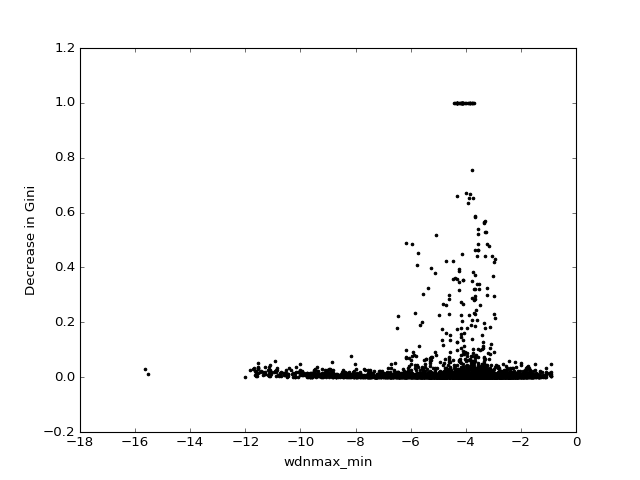

In [183]:
%matplotlib nbagg
feature_num = 40
all_gini_decreases = []
all_weighted_n_node_samples = []
for d, dt in enumerate(model_obj.best_estimator_.estimators_):
    fn = np.where(dt.tree_.feature == feature_num)
    gini_decrease = dt.tree_.impurity[fn] - (dt.tree_.weighted_n_node_samples[dt.tree_.children_left[fn]] * dt.tree_.impurity[dt.tree_.children_left[fn]] 
                          + dt.tree_.weighted_n_node_samples[dt.tree_.children_right[fn]] * dt.tree_.impurity[dt.tree_.children_right[fn]]) / dt.tree_.weighted_n_node_samples[fn].astype(float) 
    all_gini_decreases.append(gini_decrease)
    all_weighted_n_node_samples.append(dt.tree_.weighted_n_node_samples[fn] / dt.tree_.weighted_n_node_samples[0])
    plt.scatter(dt.tree_.threshold[fn], all_weighted_n_node_samples[d],
                5, 'k')
plt.xlabel(input_col_arr[feature_num])
plt.ylabel("Decrease in Gini")

<IPython.core.display.Javascript object>


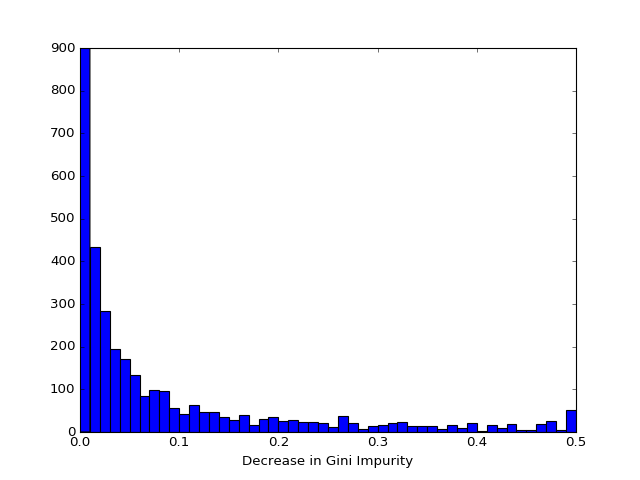

In [191]:
%matplotlib nbagg

plt.hist(np.concatenate(all_gini_decreases), 50) #weights=np.concatenate(all_weighted_n_node_samples ))

plt.xlabel("Decrease in Gini Impurity")

<IPython.core.display.Javascript object>


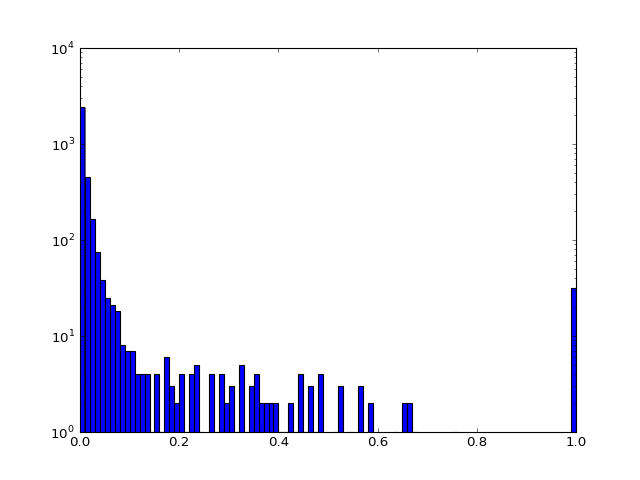

(array([  2.39300000e+03,   4.54000000e+02,   1.66000000e+02,
          7.50000000e+01,   3.80000000e+01,   2.50000000e+01,
          2.10000000e+01,   1.80000000e+01,   8.00000000e+00,
          7.00000000e+00,   7.00000000e+00,   4.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   1.00000000e+00,
        

In [188]:
plt.hist(np.concatenate(all_weighted_n_node_samples), bins=100, log=True)

<IPython.core.display.Javascript object>


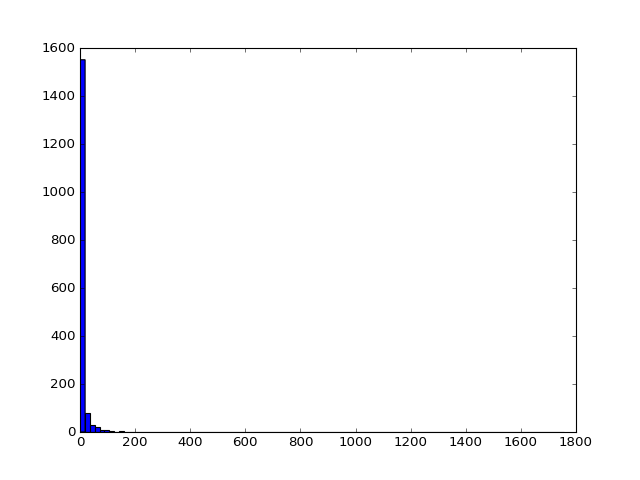

(array([  1.55100000e+03,   8.00000000e+01,   2.90000000e+01,
          1.90000000e+01,   9.00000000e+00,   7.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

In [174]:
plt.hist(dt.tree_.n_node_samples[dt.tree_.feature == -2], bins=100)

In [169]:
dt.tree_.feature.max()

275